In [181]:
import pints
import numpy as np
import math
from scipy.constants import N_A
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
import pandas as pd
from lmfit import Model

In [182]:
#Constants

Target_cell_number = 5e4
E_T_ratio = 1
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2


t_end = 60*60*5
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

kons = [1.1e5, 1.4e5, 2e5, 2.5e5]
KDs = [148e-9, 24e-9, 7e-9, 0.6e-9]
koffs = [kons[i]*KDs[i] for i in range(len(kons))]
qon = 6.5e3
qoff = 4.7e-3
rtot = 2.2e5
ftot=2.2e5
D_t = 6.8e-15
D_f = 7.4e-14

In [183]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot

    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  - k2*z[0]*(rt) + 2*1*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*1*k1off*z[1] - k5*z[1]*(rf) + 1*k2off*z[4]
    dA01 =   - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 1*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [184]:
def calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k4, k5, k6):
    
    #k2 = D_t/tumour_cell_surface_area
    k2 = 10**(-6)
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1

    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-2], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)
    
        
    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
        
    A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
    A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
    A1_E_pre_synapse = np.float64(A1_E_stst*NK_cell_IS_proportion)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    Atot =A1_pre_synapse + A2_pre_synapse + A1_E_pre_synapse
    z_0 = [A1_pre_synapse, A2_pre_synapse, A1_E_pre_synapse, 0, 0]
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = D_t/(synapse_area)
    k7 = (2*D_t/synapse_area)
    z = solve_ivp(S_two_cells, tspan, z_0, method='BDF',  rtol = 1e-4, atol=1e-3, t_eval=t, args=[k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, ftot_synapse, Atot])
    if z.success == False:
        print(z.message)
    A11 = z.y[3]
    A21 = z.y[4]
  

    crosslinks = (A11[-1] + A21[-1])
    
    
    return np.asarray(crosslinks)

In [191]:
def fc_func(Emax, Efc50, fc):

    return (Emax*(fc))/(Efc50 + (fc))

def simulate_model_individual(A0s, k4, k5, k6, Efc50, ftot, kon, koff, Emax):

    solution = np.zeros_like(A0s)
    ftot_synapse = ftot*NK_cell_IS_proportion
    for i, Ainit in enumerate(A0s):
        solution[i] = (calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k4, k5, k6))/ftot_synapse
        
    
    solution = fc_func(Emax, Efc50, solution)
    return solution

def simulate_model(A0s, parameters):
    k4 = parameters[0]
    k4 = 10**k4
    k5 = parameters[1]
    k5 = 10**k5
    k6 = parameters[2]
    k6 = 10**k6
    Efc50 = parameters[3]
    Emax = parameters[4]
    solution1 = np.zeros((len(A0s), len(kons)))
    for i, kon in enumerate(kons):
            solution1[:, i] = simulate_model_individual(A0s, k4, k5, k6, Efc50, ftot, kon, koffs[i], Emax)
        
    return solution1

def simulate_model_ls(A0s, k4, k5, k6, Efc50, Emax):
    k4 = 10**k4
    k5 = 10**k5
    k6 = 10**k6
    solutions = []
    for i, kon in enumerate(kons):
        solution1 = np.zeros((len(A0s)))
        solution1[:] = simulate_model_individual(A0s, k4, k5, k6, Efc50, ftot, kon, koffs[i], Emax)
        solutions.append(solution1)
    
    solution = np.asarray(np.concatenate(([solutions[i] for i in range(len(solutions))])))
    return solution


class model(pints.ForwardModel):

    def n_outputs(self):
         return 4
    
    def n_parameters(self):
        return 5
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

In [187]:
#extract data
data1 = []
ftot_synapse = ftot*NK_cell_IS_proportion
from pathlib import Path
pathlist = Path('/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data').glob('**/*.csv')

for path in pathlist:
    print(path)
    df = pd.read_csv(str(path))
    conc = df['CONCENTRATION'].values
    conc = conc*1e-9
    vals = df['RLU'].values
    data1.append(vals)

data = np.stack((data1), axis=1)
data2 = np.asarray(np.concatenate(([data1[i] for i in range(len(data1))])))
A0s = conc

/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/VKF94A_VHP97A_cyto.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/VKS93A_VHP97A_cyto.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/VKF94A_cyto.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_cyto_data/WT_cyto.csv


In [197]:
ls_model = Model(simulate_model_ls)
print(ls_model.param_names)
print(ls_model.independent_vars)
ls_model.set_param_hint('k4', min = -12, max = -1)
ls_model.set_param_hint('k5', min = -12, max = -1)
ls_model.set_param_hint('k6', min = -12, max = -1)
ls_model.set_param_hint('Efc50', min = 0.01, max = 0.5)
ls_model.set_param_hint('Emax', min = 1, max = 200)

parameters = ls_model.make_params(k4=-4, k5 = -9, k6=-6, Efc50=0.2, Emax=10)

result = ls_model.fit(data2, parameters, A0s=A0s)

['k4', 'k5', 'k6', 'Efc50', 'Emax']
['A0s']


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/4031190592.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/4031190592.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/4031190592.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfor

In [198]:
print(result.fit_report())

[[Model]]
    Model(simulate_model_ls)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 141
    # data points      = 36
    # variables        = 5
    chi-square         = 35.2302844
    reduced chi-square = 1.13646079
    Akaike info crit   = 9.22193656
    Bayesian info crit = 17.1395312
    R-squared          = 0.95200126
[[Variables]]
    k4:    -5.01589247 +/- 2.88144405 (57.45%) (init = -4)
    k5:    -7.43122263 +/- 0.32303947 (4.35%) (init = -9)
    k6:    -5.34538401 +/- 0.43881351 (8.21%) (init = -6)
    Efc50:  0.17935937 +/- 0.34609081 (192.96%) (init = 0.2)
    Emax:   42.3914388 +/- 56.5840814 (133.48%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(Efc50, Emax) = +0.9985
    C(k5, Efc50)   = +0.9376
    C(k4, Efc50)   = +0.9268
    C(k5, Emax)    = +0.9222
    C(k4, Emax)    = +0.9117
    C(k4, k5)      = +0.9102
    C(k6, Emax)    = -0.4680
    C(k6, Efc50)   = -0.4285
    C(k5, k6)      = -0.2836
    C(k4, k6)      

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/4031190592.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/4031190592.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/4031190592.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfor

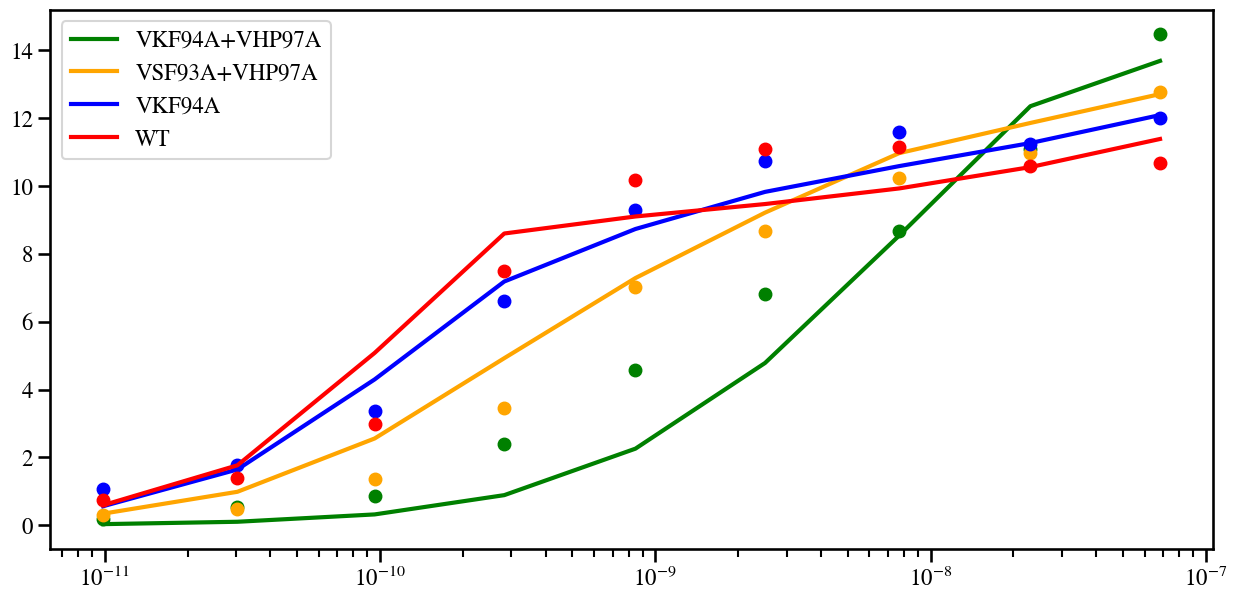

In [201]:
plt.figure(figsize=(15, 7))
param_results = result.best_values
colors=['green', 'orange', 'blue', 'red']
labels = ['VKF94A+VHP97A', 'VSF93A+VHP97A', 'VKF94A', 'WT',]
vals = simulate_model_ls(A0s, param_results['k4'], param_results['k5'], param_results['k6'], param_results['Efc50'], param_results['Emax'])
for i in range(len(kons)):
    plt.plot(A0s, data[:, i], 'o', c=colors[i])
    plt.plot(conc, vals[i*9: 9*(i+1)], label=labels[i], lw=3, c=colors[i])
plt.legend()
plt.xscale('log')
plt.show()

In [203]:
init_guesses = [param_results['k4'], param_results['k5'], param_results['k6'], param_results['Efc50'], param_results['Emax']]

In [204]:
class LogPosteriorWrapper(pints.LogPDF):
    def __init__(self, log_pdf):
        self._log_pdf = log_pdf

    def __call__(self, parameters):
        # Create parameter container
        params = np.empty(shape=len(parameters)+3)

        # Fill container with parameters
        # (This solution is specific to the above presented problem)
        params[:5] = np.asarray(parameters[:5])
        params[5] = parameters[5]
        params[6] = parameters[5]
        params[7] = parameters[5]
        params[8] = parameters[5]

        return self._log_pdf(params)

    def n_parameters(self):
        return self._log_pdf.n_parameters() - 3

In [212]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = init_guesses + [0.01 for i in range(4)]
print(log_likelihood.n_parameters())
#print(parameters)
log_prior = pints.UniformLogPrior(
    [-12, -12, -12, 0.01, 0.8, 0.0001, 0.0001, 0.0001, 0.0001],
    [-2, -2, -2, 0.5, 200, 3, 3, 3, 3]
)

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

log_posterior_fixed_noise = LogPosteriorWrapper(log_posterior)


9


In [213]:
parameters_fixed_noise = init_guesses + [0.0001]

In [214]:
xs = [
    np.array(parameters_fixed_noise) * 0.9,
    np.array(parameters_fixed_noise) * 1.01,
    np.array(parameters_fixed_noise) * 1.15
]

In [215]:
mcmc = pints.MCMCController(log_posterior, 3, xs)
mcmc.set_max_iterations(20000)
chains = mcmc.run()

ValueError: All initial positions must have the same dimension as the given LogPDF.

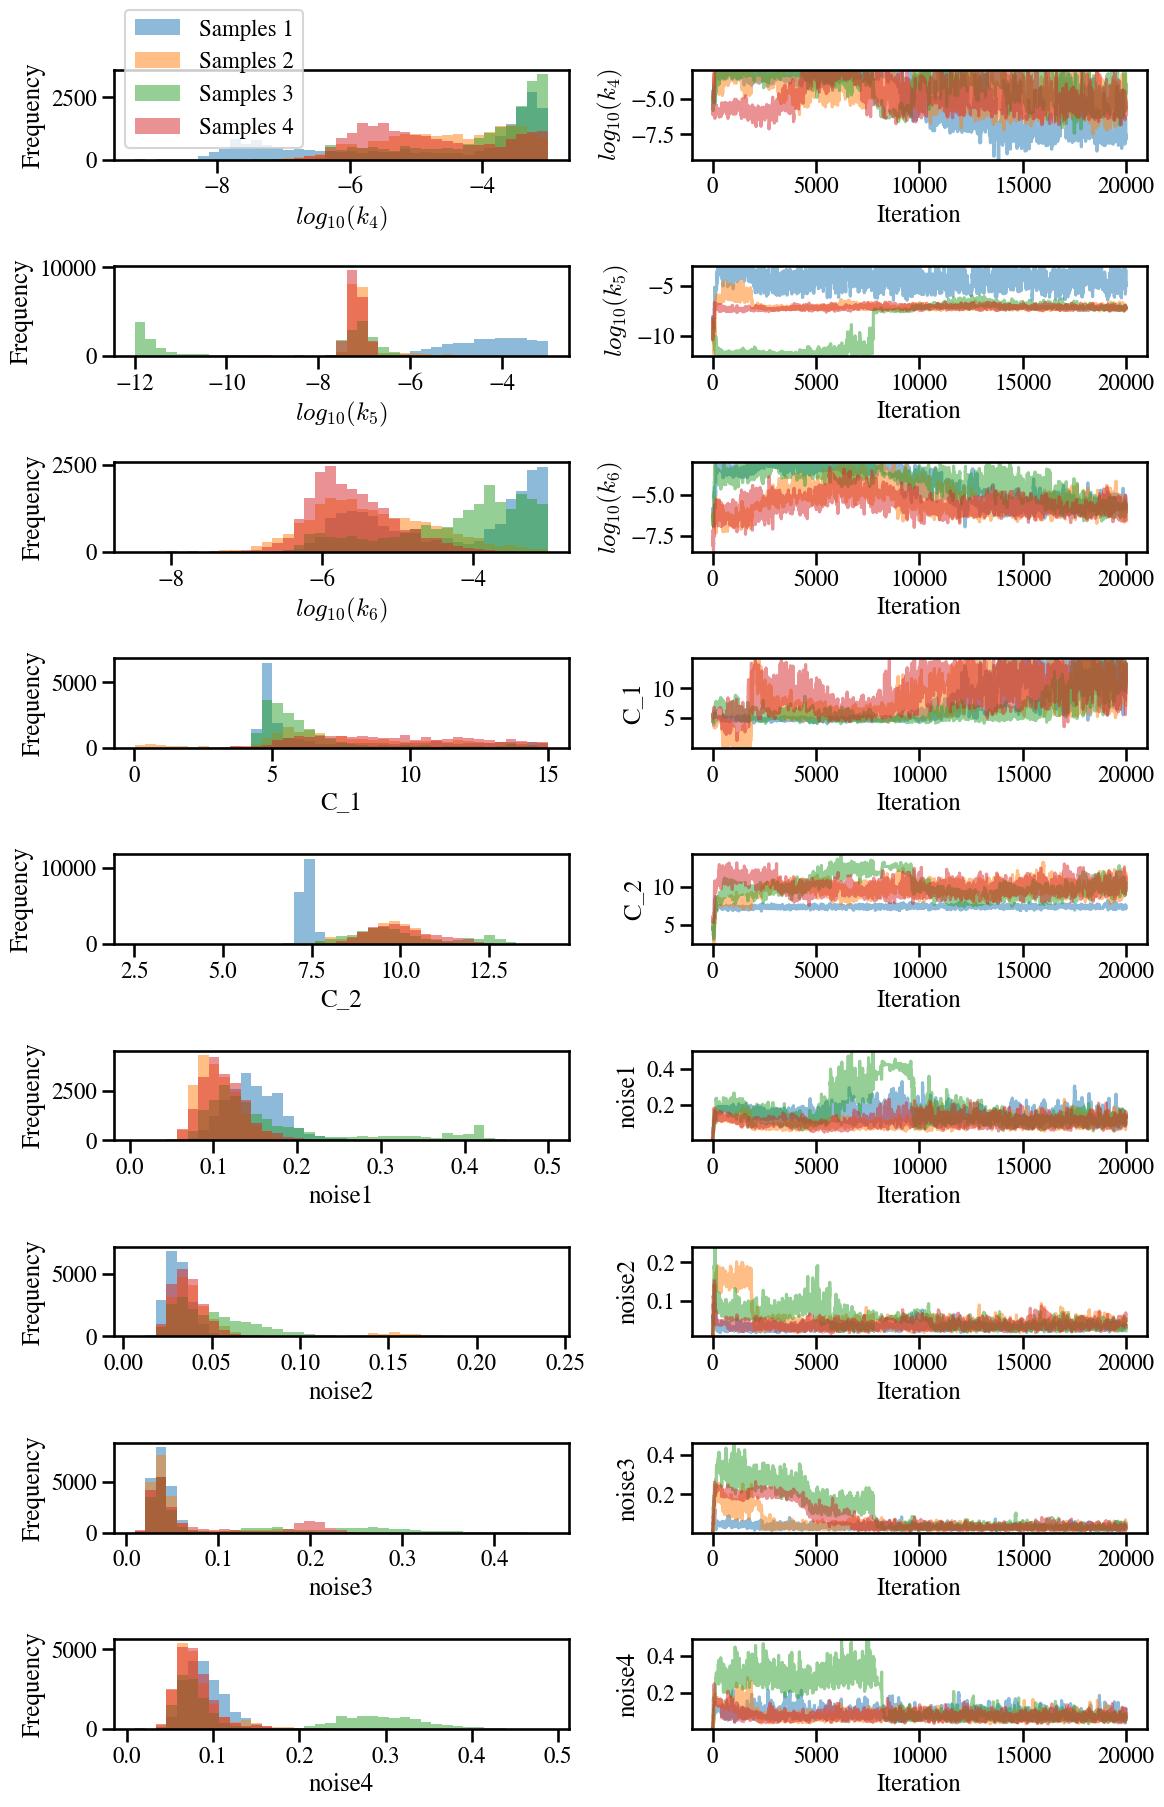

In [ ]:
import pints.plot
pints.plot.trace(chains, parameter_names=[r'$log_{10}(k_4)$', r'$log_{10}(k_5)$', r'$log_{10}(k_6)$', r'C_1', r'C_2', 'noise1', 'noise2', 'noise3', 'noise4'])
plt.show()

In [ ]:
chain = chains[0]
chain = chain[15000:]
chains1 = chains[:, 15000 :]

In [ ]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=[r'log10(k4)', r'log10(k5)', r'log10(k6)', r'C_1', r'C_2',  'noise1', 'noise2', 'noise3', 'noise4'])
print(results)


param      mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
---------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
log10(k4)  -5.48   1.24    -7.90   -6.16  -5.41  -4.62  -3.29    1.33    264.06  0.02
log10(k5)  -6.44   1.28    -7.40   -7.23  -7.08  -6.35  -3.27    3.15    267.21  0.02
log10(k6)  -5.61   0.51    -6.37   -5.98  -5.70  -5.33  -4.41    1.23    237.36  0.01
C_1        10.67   2.67    5.61    8.57   10.90  12.98  14.76    1.16    280.00  0.02
C_2        9.31    1.37    7.17    7.96   9.51   10.27  11.77    1.97    316.46  0.02
noise1     0.12    0.03    0.08    0.10   0.12   0.13   0.19     1.10    529.68  0.03
noise2     0.04    0.01    0.02    0.03   0.04   0.04   0.06     1.08    464.22  0.03
noise3     0.04    0.01    0.02    0.03   0.04   0.04   0.06     1.02    350.00  0.02
noise4     0.08    0.02    0.05    0.06   0.07   0.09   0.12     1.05    500.16  0.03


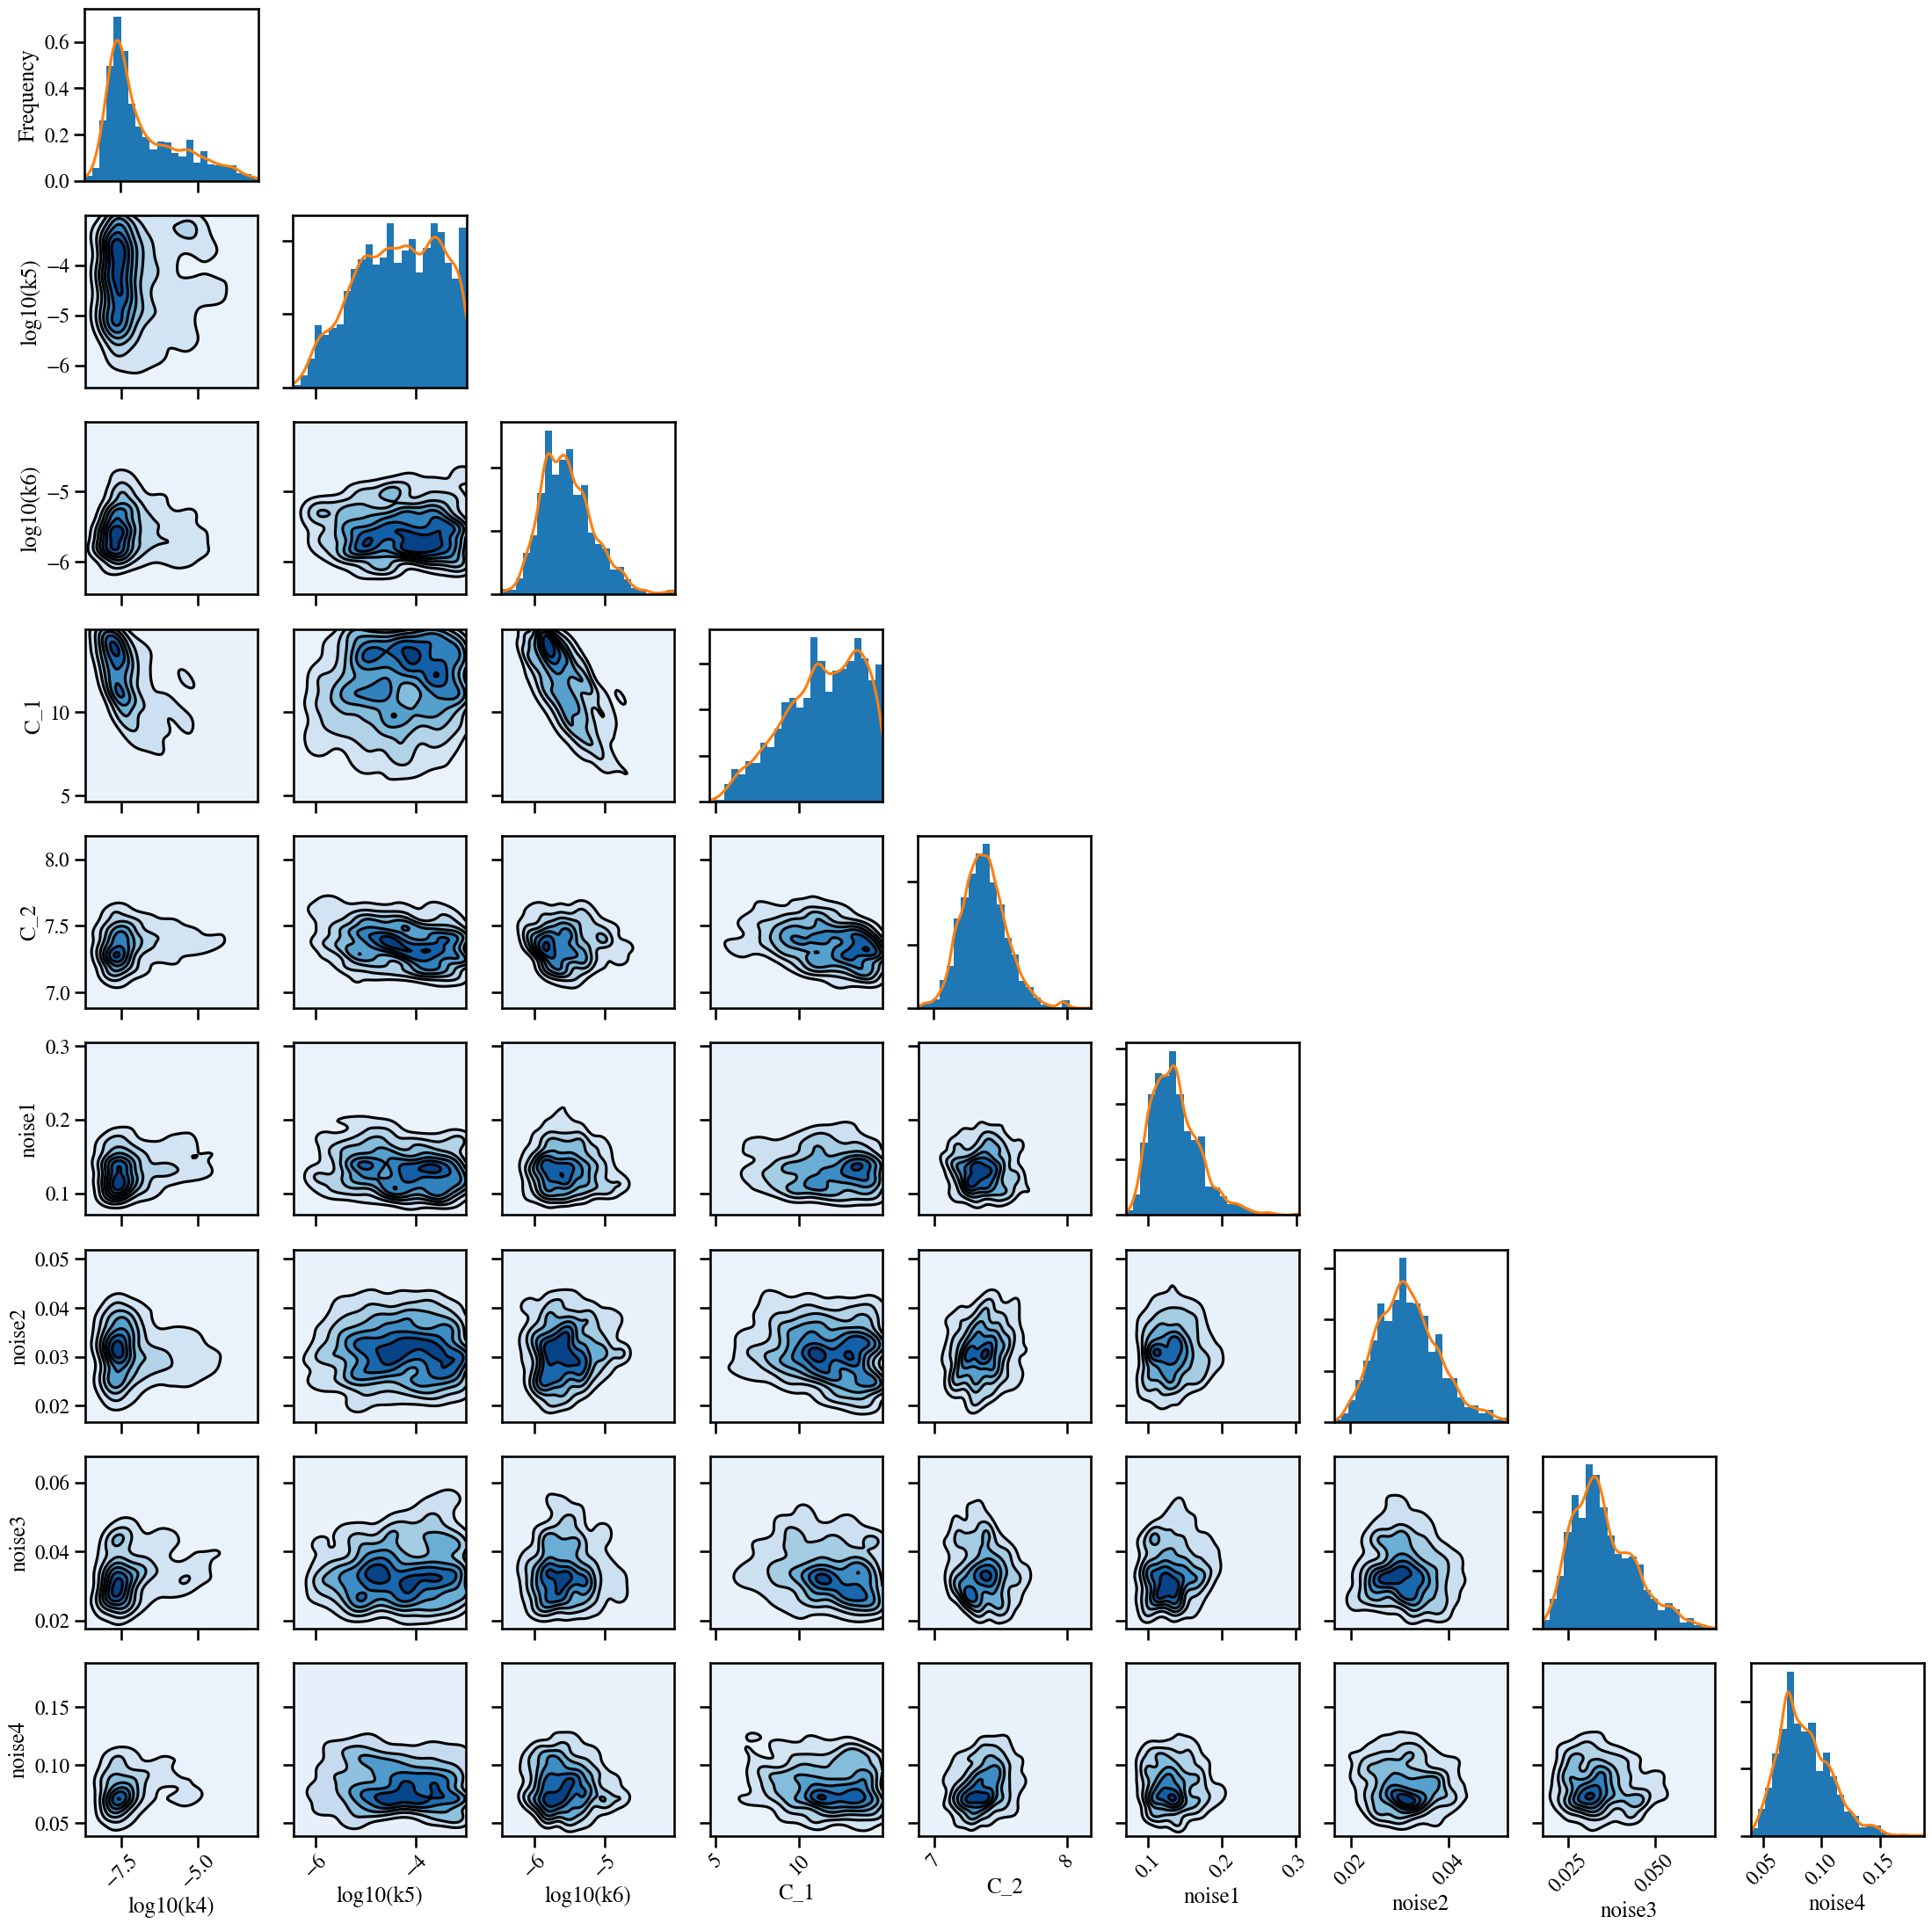

In [ ]:
pints.plot.pairwise(chain, kde=True,  parameter_names=[r'log10(k4)', r'log10(k5)', r'log10(k6)', r'C_1', r'C_2', 'noise1', 'noise2', 'noise3', 'noise4'])
plt.show()

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfor

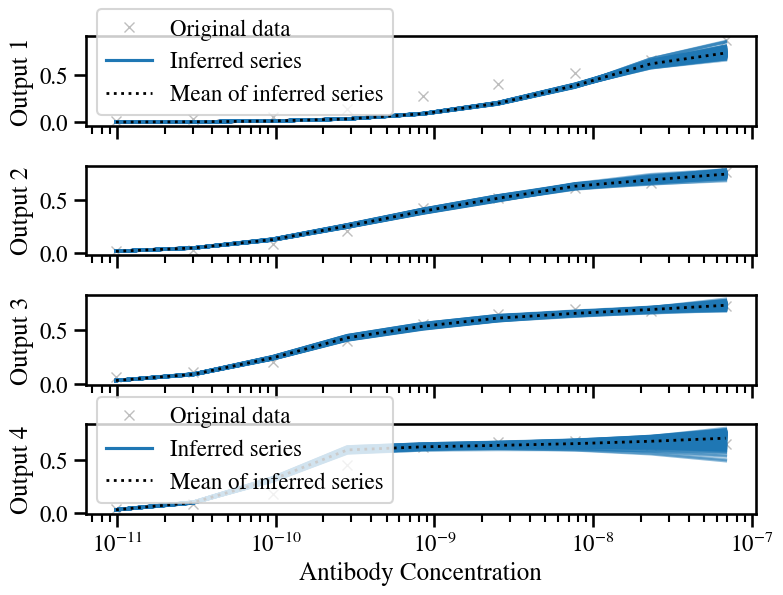

In [ ]:
fig, axes = pints.plot.series(chains1[0], problem)

#fig.set_size_inches(12,4.5)
#plt.plot(A0s1, values, c='orange', label='data')
plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [ ]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'log10(k4)', r'log10(k5)', r'log10(k6)', r'C_1', r'C_2', 'noise1', 'noise2', 'noise3', 'noise4']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

In [ ]:
print(results_dic['mean'])

[np.float64(-5.476769007585353), np.float64(-6.440124577937517), np.float64(-5.6107587761658255), np.float64(10.674825770927024), np.float64(9.308149427992781), np.float64(0.1190620426530564), np.float64(0.0368385994924126), np.float64(0.03651631751151487), np.float64(0.07724359872770192)]


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfor

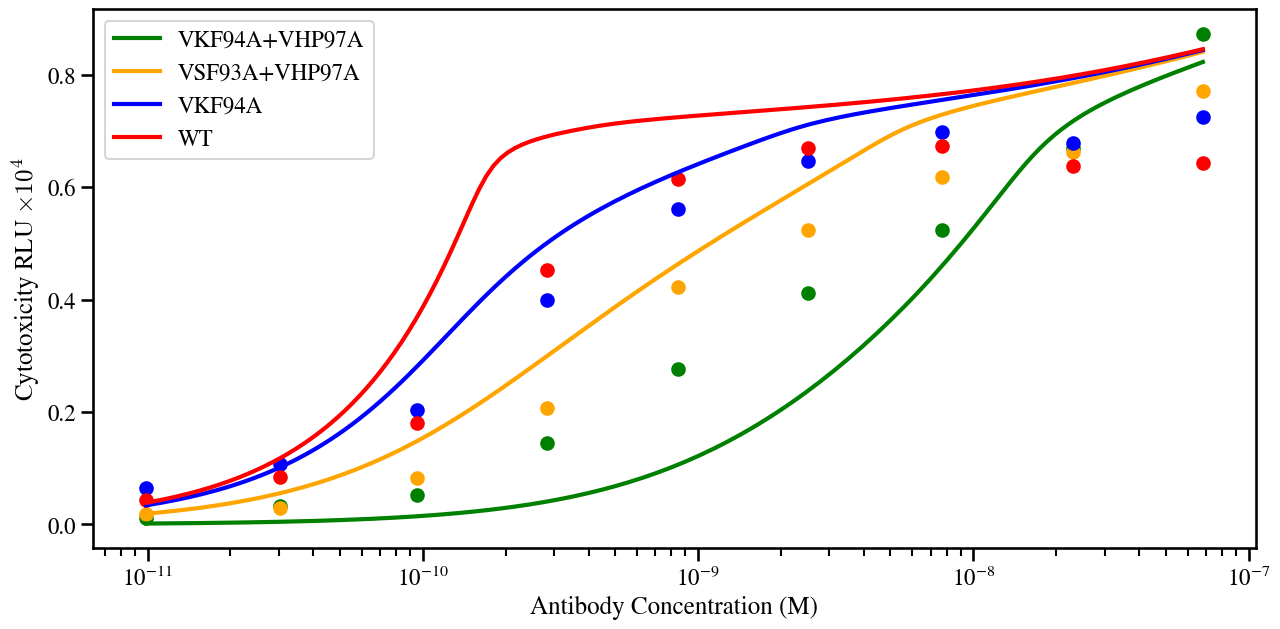

In [ ]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
A0s = np.geomspace(np.min(conc), np.max(conc), 150)
SMALL_SIZE =10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
import seaborn as sns
sns.set_context('talk')

plt.figure(figsize=(15, 7))
plt.xlabel('Antibody Concentration (M)')
plt.ylabel(r'Cytotoxicity RLU $\times 10^4$')

parameters=results_dic['mean']
#parameters = [np.float64(-6.337053447734297), np.float64(-8.193659215136035), np.float64(-7.0971636246953596), np.float64(0.3040548518999335), np.float64(0.8786846642185841), np.float64(0.13890972065515947), np.float64(0.04155340220718492), np.float64(0.03355178641841207), np.float64(0.06273472762480574)]
sim = simulate_model(A0s, parameters)
colors=['green', 'orange', 'blue', 'red']
labels = ['VKF94A+VHP97A', 'VSF93A+VHP97A', 'VKF94A', 'WT',]
for i in range(len(kons)):
    plt.plot(A0s, sim[:, i], c=colors[i], label=labels[i], lw=3)
    plt.scatter(conc, data[:, i], c=colors[i])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [ ]:
def simulate_model_individual1(A0s, k4, k5, k6, ftot, kon, koff):

    solution = np.zeros_like(A0s)
    ftot_synapse = ftot*NK_cell_IS_proportion
    for i, Ainit in enumerate(A0s):
        solution[i] = (calc_crosslinks_odes(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot, E_T_ratio, k4, k5, k6))/ftot_synapse
        

    return solution

In [ ]:
params = results_dic['mean']
k4=params[0]
k4 = 10**k4
k5=params[1]
k5 = 10**k5
k6=params[2]
k6=10**k6
A0s = np.geomspace(1e-12, 1e-5, 100)
ftot=2.2e5
solution1 = np.zeros((len(A0s), len(kons)))
for i, kon in enumerate(kons):
        solution1[:, i] = simulate_model_individual1(A0s, k4, k5, k6, ftot, kon, koffs[i])

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A1_pre_synapse = np.float64(A1_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A2_pre_synapse = np.float64(A2_st_sin*tumour_cell_IS_proportion)
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_51703/1844721694.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfor

ValueError: setting an array element with a sequence.

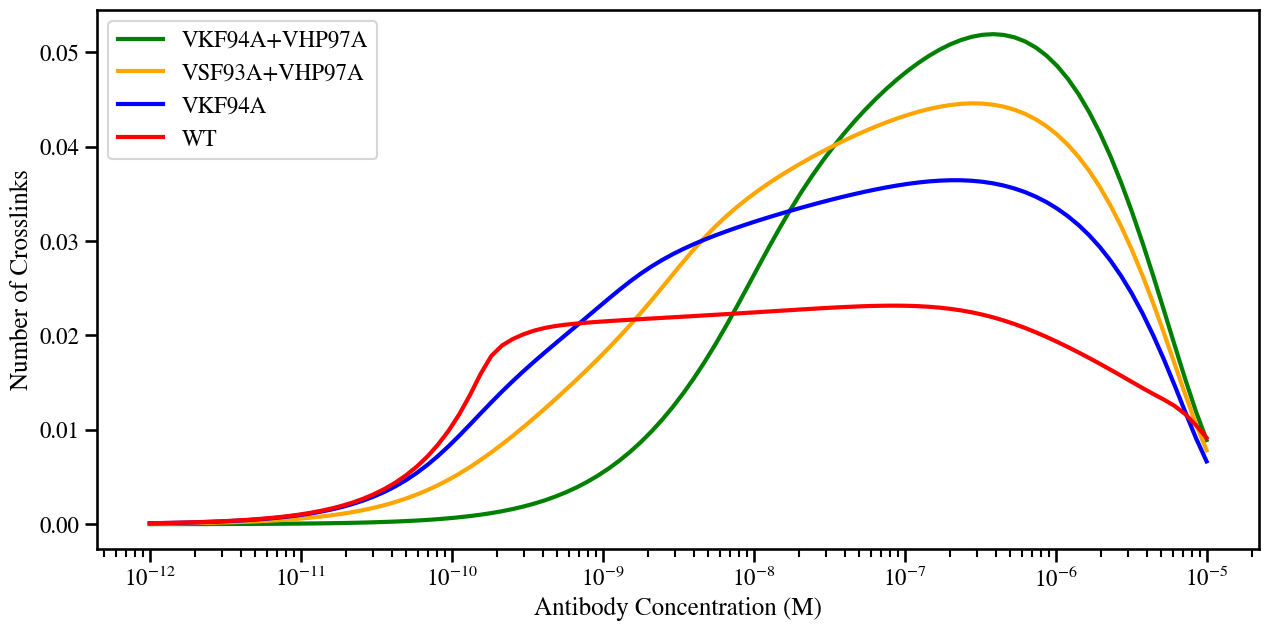

In [ ]:
plt.figure(figsize=(15, 7))
plt.xlabel('Antibody Concentration (M)')
plt.ylabel('Number of Crosslinks')

colors=['green', 'orange', 'blue', 'red']
labels = ['VKF94A+VHP97A', 'VSF93A+VHP97A', 'VKF94A', 'WT',]
for i in range(len(kons)):
    plt.plot(A0s, solution1[:, i], c=colors[i], label=labels[i], lw=3)
plt.xscale('log')
#plt.ylim(0, 0.15)
plt.legend(loc='best')
plt.show()